***DecisionTreeClassifier for Version 1***

In [23]:
from sklearn.tree import export_graphviz 
from sklearn.model_selection import StratifiedShuffleSplit # For creating stratified splits of the dataset
from sklearn.metrics import mean_squared_error # For computing the mean squared error metric
from sklearn.tree import DecisionTreeRegressor # For creating a decision tree regressor model
from sklearn.model_selection import GridSearchCV # For performing grid search with cross-validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # For computing classification metrics
from sklearn.tree import DecisionTreeClassifier # For creating a decision tree classifier model

from io import StringIO
from IPython.display import Image, display

import pandas as pd

In [24]:
data = pd.read_csv("C:/Assignment Data v2024.2/overtakes_v1.csv")

In [25]:
data.head()

,InitialSeparationM,OvertakingSpeedMPS,OncomingSpeedMPS,Success
0,187.3,36.3,17.8,False
1,132.3,43.2,27.8,False
2,141.8,36.5,14.5,True
3,185.7,34.9,20.1,False
4,149.6,25.7,21.8,False


In [26]:
data.dtypes

InitialSeparationM    float64
OvertakingSpeedMPS    float64
OncomingSpeedMPS      float64
Success                  bool
dtype: object

In [27]:
data['Success'] = data.Success.replace('True', 0).replace('False', 1).astype(int)

In [28]:
feature_cols = [x for x in data.columns if x not in 'Success']

In [29]:
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=10, random_state=42)

train_idx,test_idx = next(strat_shuff_split.split(data[feature_cols], data['Success']))

x_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Success']

x_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'Success']

In [30]:
y_train.value_counts()

0    50
1    40
Name: Success, dtype: int64

In [31]:
y_train.value_counts(normalize=True).sort_index()

0    0.555556
1    0.444444
Name: Success, dtype: float64

In [32]:
dt = DecisionTreeClassifier()
dt = dt.fit(x_train,y_train)

dt.tree_.node_count, dt.tree_.max_depth

(17, 6)

In [33]:
def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy': accuracy_score(y_true,y_pred),
                      'precision': precision_score(y_true,y_pred),
                      'recall' : recall_score(y_true,y_pred),
                      'f1' : f1_score(y_true, y_pred)},
                      name = label)

**record this ollie**

In [34]:
y_train_pred = dt.predict(x_train)
y_test_pred = dt.predict(x_test)


train_test_full_error = pd.concat([measure_error(y_train,y_train_pred, 'train'),
                                   measure_error(y_test,y_test_pred, 'test')], 
                                   axis=1)
train_test_full_error

,train,test
accuracy,1.0,0.700000
precision,1.0,0.750000
recall,1.0,0.600000
f1,1.0,0.666667


In [35]:
param_grid = {'max_depth' : range(1, dt.tree_.max_depth+1, 2),
                }

#GridSearchCV

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)
GR = GR.fit(x_train, y_train)

In [36]:
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth # Display node count and max depth of best estimator


(15, 5)

In [37]:
# Predict on training and test sets using the best estimator from GridSearchCV
y_train_pred_gr = GR.predict(x_train)
y_test_pred_gr = GR.predict(x_test)

# Calculate and display error metrics for both sets using the best estimator
train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                 measure_error(y_test, y_test_pred_gr, 'test')],
                                axis=1)
train_test_gr_error


In [38]:
# Exclude 'success' from feature columns for regression task
feature_cols = [x for x in data.columns if x != 'Success']

# Slice the data into new training and test sets for regression task
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Success']
X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'Success']

In [39]:
# Initialize and fit a DecisionTreeRegressor
dr = DecisionTreeRegressor().fit(X_train, y_train)

# Define a parameter grid for GridSearchCV for regression task
param_grid = {'max_depth':range(1, dr.tree_.max_depth+1, 2),
              'max_features': range(1, len(dr.feature_importances_)+1)}

# Initialize and fit a GridSearchCV with a DecisionTreeRegressor
GR_success = GridSearchCV(DecisionTreeRegressor(random_state=42),
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error',
                        n_jobs=-1)
GR_success = GR_success.fit(X_train, y_train)

In [40]:
GR_success.best_estimator_.tree_.node_count, GR_success.best_estimator_.tree_.max_depth

(15, 3)

In [41]:
# Predict on training and test sets using the best estimator for regression task
y_train_pred_gr_success = GR_success.predict(x_train)
y_test_pred_gr_success  = GR_success.predict(x_test)

# Calculate and display mean squared error for both sets using the best estimator for regression task
train_test_gr_success_error = pd.Series({'train': mean_squared_error(y_train, y_train_pred_gr_success),
                                       'test':  mean_squared_error(y_test, y_test_pred_gr_success)},
                                        name='MSE').to_frame().T
train_test_gr_success_error

,train,test
MSE,0.053961,0.291615


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('dark')

%matplotlib inline

[Text(0.5, 0, 'Test'), Text(0, 0.5, 'Predict'), (0.0, 5.0), (0.0, 5.0)]

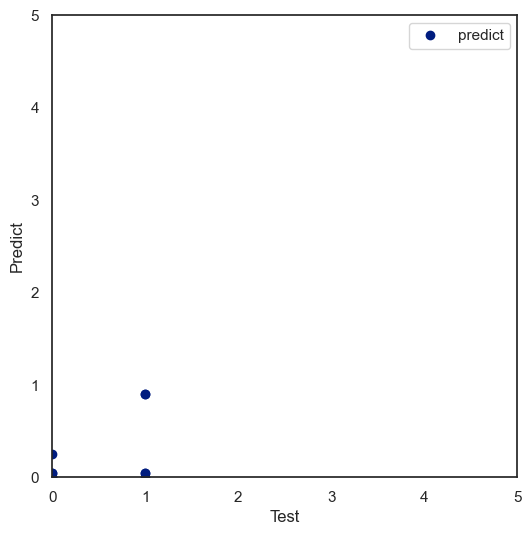

In [43]:

fig = plt.figure(figsize=(6,6))
ax = plt.axes()

ph_test_predict = pd.DataFrame({'test':y_test.values,
                                'predict': y_test_pred_gr_success}).set_index('test').sort_index()

ph_test_predict.plot(marker='o', ls='', ax=ax)
ax.set(xlabel='Test', ylabel='Predict', xlim=(0,5), ylim=(0,5))